In [59]:
from pathlib import Path

DATA_PATH = Path('data')
PATH= DATA_PATH/"mnist"
FILENAME = "mnist.pkl.gz"


In [60]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")


(50000, 784)


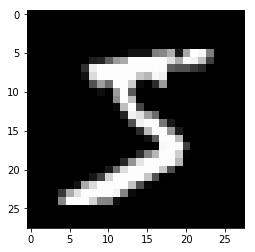

In [61]:
from matplotlib import pyplot

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [62]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

torch.Size([50000, 784]) torch.Size([50000]) torch.Size([10000, 784]) torch.Size([10000])


In [63]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2)
        )
        
        self.Decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.Encoder(x)
        
        x = self.Decoder(x)
        
        return x

In [69]:
import torch.nn.functional as F

def loss_batch(output, source, target, loss_func, opt=None):
    
    loss = loss_func(output, target)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    
    return loss.item(), len(target)

In [65]:
import numpy as np
from torchvision.utils import save_image


def train(epochs, model, train_dl, valid_dl, loss_func, opt, out_dir):
    loss_record = 100
    for epoch in range(epochs):
        
        model.train()
        for source, target in train_dl:
            output = model(source)
            loss_batch(output, source, source, loss_func, opt)
            
        
        model.eval()
        with torch.no_grad():
            losses = []
            nums = []
            for source, target in valid_dl:
                output = model(source)
                loss, num = loss_batch(output, source, source, loss_func) 
                losses.append(loss)
                nums.append(num)
            if epoch%10==0:
                pic = torch.cat((output, source), 0)
                pic = pic.view(pic.size(0),1,28,28)
                save_image(pic, './{}/image_{}.png'.format(out_dir, epoch))
            
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            if valid_loss < loss_record:
                torch.save(model.state_dict(),'./{}/ae_model.pth'.format(out_dir))
                print("save model epoch {} {}".format(epoch, valid_loss))
                loss_record = valid_loss
            if epoch%10==0:
                print(epoch, valid_loss)
                

In [66]:
from torch.utils.data import TensorDataset, DataLoader
bs = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_ds = TensorDataset(x_train.to(device), y_train.to(device))
valid_ds = TensorDataset(x_valid.to(device), y_valid.to(device))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

In [67]:
import torch.optim as opt




lr = 0.001
model = AutoEncoder()
print(model)
model.to(device)
criterion = nn.MSELoss()
opt = opt.Adam(model.parameters(), lr = lr, weight_decay=1e-5)

AutoEncoder(
  (Encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (Decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [68]:
epochs = 10000
out_dir = 'data/mnist_ae_png'
train(epochs, model, train_dl, valid_dl, criterion, opt, out_dir=out_dir)

save model epoch 0 0.21367176070809366
0 0.21367176070809366
save model epoch 1 0.20239998653531074
save model epoch 2 0.1960037000477314
save model epoch 3 0.1925588494539261
save model epoch 4 0.18944339394569398
save model epoch 5 0.1881156548857689
save model epoch 6 0.1851861310005188
save model epoch 7 0.1840585446357727
save model epoch 8 0.18198939874768258
save model epoch 9 0.17992980554699897
10 0.1808965528011322
save model epoch 11 0.17805790141224861


KeyboardInterrupt: 